In [3]:
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine
import time
import pdb
import bdb  # Added to handle BdbQuit
from collections import Counter

In [4]:
print(pyodbc.drivers())

NameError: name 'pyodbc' is not defined

In [4]:
if 1: # Create SQLAlchemy engine
    connection_string = (
        f"mssql+pyodbc://{"LouisHaehle"}:{"QuiltStanceCurler51"}"
        f"@10.0.30.16:1433/RTID_SourceData"
        f"?driver=ODBC+Driver+17+for+SQL+Server"
        f"&TrustServerCertificate=yes"
        f"&Connection+Timeout=5"
        )
    engine = create_engine(connection_string)

In [5]:
# Query all rows from the US_HY_NVR_TEST_2023_2025_REDO table
live_query = """
    SELECT [REPORT_YEAR_WEEK]
      ,[VEH_AT_PHYS_LOC]
      ,[VIN_SOLD]
      ,[INV_MIN_VIN_SOLD_DT]
      ,[DAYS_LSTD_BFR_SLD]
      ,[SRC_VEH_FIRST_SCRAPED_DT]
      ,[TRIM_DESCRIPTION]
      ,[NVI_OWNSHP_DT]
      ,[INV_LST_PRCE_AMT]
      ,[INV_MSRP_AMT]
      ,[NVI_EFCTV_START_DT]
      ,[NVI_CENSUS_TRACT]
      ,[NVI_RPT_YYYYMM]
      ,[SLS_REPORT_YEAR_MONTH]
      ,[SALES_DT]
      ,[CATG_CD]
      ,[INV_CENSUS_TRACT]
      ,[INV_CONTROL_NBR]
      ,[INV_DEALER_NAME]
      ,[INV_TOWN_NAME]
      ,[INV_STATE_ABBRV]
      ,[SLS_CENSUS_TRACT]
      ,[SLS_CONTROL_NBR]
      ,[SLS_DEALER_NAME]
      ,[SLS_TOWN_NAME]
      ,[SLS_STATE_ABBRV]
      ,[NVI_CONTROL_NBR]
      ,[NVI_DEALER_NAME]
      ,[NVI_TOWN_NAME]
      ,[NVI_STATE_ABBRV]
      ,[MAKE_DESC]
      ,[MODEL_DESC]
      ,[SERIES_TEXT]
      ,[FUEL_DESC]
      ,[SEGMENT_DESC]
      ,[ADVNC_VEH_TYPE_DESC]
      ,[VEH_MDL_YR]
      ,[MODEL_KEY_SHORT]
      ,[SLS_VEHICLE_COUNT]
      ,[INV_COUNT]
  FROM [RTID_SourceData].[SPGM_Live].[SPGM_Weekly_INV_NVI_SLS_20251107]
"""

# Execute the query and fetch all rows
full_df_live = pd.read_sql(live_query, engine)

# Display the shape and first few rows of the DataFrame
print(f"Total rows fetched: {len(full_df_live):,}")
print(full_df_live.head())

Total rows fetched: 30,625,458
  REPORT_YEAR_WEEK VEH_AT_PHYS_LOC  VIN_SOLD INV_MIN_VIN_SOLD_DT  \
0          2025-42               Y       0.0          1899-12-30   
1          2025-36               Y       0.0          1899-12-30   
2          2025-38               Y       2.0          2025-09-30   
3          2025-41               Y       0.0          1899-12-30   
4          2025-37               N       0.0          1899-12-30   

   DAYS_LSTD_BFR_SLD SRC_VEH_FIRST_SCRAPED_DT TRIM_DESCRIPTION NVI_OWNSHP_DT  \
0             -999.0               2025-08-05               SE    1899-12-30   
1             -999.0               2024-11-14   1500 ELEVATION    1899-12-30   
2               62.0               2025-07-30         350 BASE    2025-10-08   
3             -999.0               2025-09-28       150 TREMOR    1899-12-30   
4             -999.0               2025-07-12        PREFERRED    1899-12-30   

   INV_LST_PRCE_AMT  INV_MSRP_AMT  ...   MAKE_DESC MODEL_DESC SERIES_TEXT  \
0 

In [14]:
def compare_date_columns(df, col1, col2):
    """
    Compare two date columns and calculate the percentage where col1 is earlier than col2.
    Dates before 1950 are treated as "event did not happen yet" (effectively future dates).
    
    Parameters:
    df: DataFrame containing the date columns
    col1: Name of the first date column
    col2: Name of the second date column
    
    Returns:
    Dictionary with statistics about the comparison
    """
    # Convert columns to datetime if not already
    df[col1] = pd.to_datetime(df[col1], errors='coerce')
    df[col2] = pd.to_datetime(df[col2], errors='coerce')
    
    # Define cutoff date for "event did not happen"
    cutoff_date = pd.Timestamp('1950-01-01')
    
    # Create masks for valid dates (not NaT and >= 1950)
    col1_valid = df[col1].notna() & (df[col1] >= cutoff_date)
    col2_valid = df[col2].notna() & (df[col2] >= cutoff_date)
    
    # Count valid comparisons: at least one date must be valid (>= 1950)
    valid_comparisons = col1_valid | col2_valid
    valid_count = valid_comparisons.sum()
    
    if valid_count == 0:
        return {
            'total_rows': len(df),
            'valid_rows': 0,
            'col1_earlier_count': 0,
            'col1_earlier_percentage': 0.0
        }
    
    # Count where col1 is earlier than col2:
    # Case 1: Both valid - col1 < col2
    # Case 2: col1 valid, col2 invalid (before 1950 or NaT) - col1 happened, col2 didn't, so col1 is earlier
    # Case 3: col1 invalid, col2 valid - col1 didn't happen, col2 did, so col1 is NOT earlier
    
    both_valid = col1_valid & col2_valid
    col1_valid_col2_not = col1_valid & ~col2_valid
    
    earlier_mask = (both_valid & (df[col1] < df[col2])) | col1_valid_col2_not
    earlier_count = earlier_mask.sum()
    earlier_percentage = (earlier_count / valid_count) * 100
    
    return {
        'total_rows': len(df),
        'valid_rows': valid_count,
        'col1_earlier_count': earlier_count,
        'col1_earlier_percentage': earlier_percentage
    }


# Example usage with your dataframe:
result = compare_date_columns(full_df_live, 'SALES_DT', 'NVI_EFCTV_START_DT')

print(f"Total rows: {result['total_rows']:,}")
print(f"Rows with valid comparisons: {result['valid_rows']:,}")
print(f"Rows where SALES_DT is earlier: {result['col1_earlier_count']:,}")
print(f"Percentage where first column is earlier: {result['col1_earlier_percentage']:.2f}%")

Total rows: 26,912,186
Rows with valid comparisons: 12,617,706
Rows where SALES_DT is earlier: 5,785,308
Percentage where first column is earlier: 45.85%


In [13]:
full_df_live.head(30)

,SALES_DT,NVI_EFCTV_START_DT,NVI_OWNSHP_DT
0,1899-12-30,1899-12-30 00:00:00,1899-12-30
1,1899-12-30,1899-12-30 00:00:00,1899-12-30
2,1899-12-30,1899-12-30 00:00:00,1899-12-30
3,1899-12-30,1899-12-30 00:00:00,1899-12-30
4,1899-12-30,1899-12-30 00:00:00,1899-12-30
5,1899-12-30,2025-08-04 03:57:32,2025-06-02
6,1899-12-30,1899-12-30 00:00:00,1899-12-30
7,1899-12-30,2025-10-03 22:09:57,2025-09-29
8,2025-10-08,1899-12-30 00:00:00,1899-12-30
9,1899-12-30,1899-12-30 00:00:00,1899-12-30


In [15]:
def compare_date_columns_both_valid(df, col1, col2):
    """
    Compare two date columns and calculate the percentage where col1 is earlier than col2.
    Only compares rows where BOTH dates are valid (not NaT and >= 1950).
    
    Parameters:
    df: DataFrame containing the date columns
    col1: Name of the first date column
    col2: Name of the second date column
    
    Returns:
    Dictionary with statistics about the comparison
    """
    # Convert columns to datetime if not already
    df[col1] = pd.to_datetime(df[col1], errors='coerce')
    df[col2] = pd.to_datetime(df[col2], errors='coerce')
    
    # Define cutoff date for "event did not happen"
    cutoff_date = pd.Timestamp('1950-01-01')
    
    # Create masks for valid dates (not NaT and >= 1950)
    col1_valid = df[col1].notna() & (df[col1] >= cutoff_date)
    col2_valid = df[col2].notna() & (df[col2] >= cutoff_date)
    
    # Only consider rows where BOTH dates are valid
    both_valid = col1_valid & col2_valid
    valid_count = both_valid.sum()
    
    if valid_count == 0:
        return {
            'total_rows': len(df),
            'both_valid_rows': 0,
            'col1_earlier_count': 0,
            'col1_earlier_percentage': 0.0
        }
    
    # Count where col1 is earlier than col2 (only when both are valid)
    earlier_mask = both_valid & (df[col1] < df[col2])
    earlier_count = earlier_mask.sum()
    earlier_percentage = (earlier_count / valid_count) * 100
    
    return {
        'total_rows': len(df),
        'both_valid_rows': valid_count,
        'col1_earlier_count': earlier_count,
        'col1_earlier_percentage': earlier_percentage
    }


# Example usage with your dataframe:
result = compare_date_columns_both_valid(full_df_live, 'SALES_DT', 'NVI_EFCTV_START_DT')

print(f"Total rows: {result['total_rows']:,}")
print(f"Rows with both dates valid: {result['both_valid_rows']:,}")
print(f"Rows where SALES_DT is earlier: {result['col1_earlier_count']:,}")
print(f"Percentage where first column is earlier: {result['col1_earlier_percentage']:.2f}%")

Total rows: 26,912,186
Rows with both dates valid: 0
Rows where SALES_DT is earlier: 0
Percentage where first column is earlier: 0.00%


In [21]:
# Define cutoff date for valid dates
cutoff_date = pd.Timestamp('1950-01-01')

# Convert SALES_DT to datetime if not already
full_df_live['SALES_DT'] = pd.to_datetime(full_df_live['SALES_DT'], errors='coerce')

# Create a column for valid SALES_DT (not NaT and >= 1950)
full_df_live['valid_sales_dt'] = (full_df_live['SALES_DT'].notna() & 
                                   (full_df_live['SALES_DT'] >= cutoff_date)).astype(int)

# Group by MAKE_DESC and calculate statistics
make_stats = full_df_live.groupby('MAKE_DESC').agg(
    total_rows=('SALES_DT', 'count'),
    valid_sales_dt_count=('valid_sales_dt', 'sum')
).reset_index()

# Calculate percentage
make_stats['valid_sales_dt_percentage'] = (make_stats['valid_sales_dt_count'] / make_stats['total_rows']) * 100

# Sort by percentage descending
make_stats = make_stats.sort_values('valid_sales_dt_percentage', ascending=False)

# Export to Excel
output_file = 'SALES_DT_validity_by_MAKE_DESC.xlsx'
make_stats.to_excel(output_file, index=False, sheet_name='SALES_DT_Validity')

print(f"Results exported to: {output_file}")
print(f"Total number of makes: {len(make_stats)}")
print("\nFirst 10 rows:")
print(make_stats.head(10).to_string(index=False))

Results exported to: SALES_DT_validity_by_MAKE_DESC.xlsx
Total number of makes: 41

First 10 rows:
MAKE_DESC  total_rows  valid_sales_dt_count  valid_sales_dt_percentage
    LEXUS      344649                120179                  34.869969
   SUBARU      751306                224394                  29.867191
   TOYOTA     2308492                670703                  29.053729
    HONDA     1979782                569590                  28.770339
 INFINITI       89792                 23015                  25.631459
    MAZDA      643343                159408                  24.778073
   NISSAN     1452607                357733                  24.626964
CHEVROLET     3206918                776154                  24.202490
    ACURA      266297                 64419                  24.190659
      GMC     1104657                252716                  22.877328


In [5]:
# Display number of rows in full_df_live
print(f"Number of rows in full_df_live: {len(full_df_live):,}")
print(f"Shape of full_df_live: {full_df_live.shape}")

Number of rows in full_df_live: 26,912,186
Shape of full_df_live: (26912186, 4)


In [1]:
import matplotlib.pyplot as plt

def plot_date_distribution(df, date_column, bins=50, figsize=(12, 6), title=None, cutoff_year=1950):
    """
    Plot the distribution of dates in a datetime column.
    Filters out dates before the cutoff year for cleaner visualization.
    
    Parameters:
    df: DataFrame containing the date column
    date_column: Name of the datetime column to plot
    bins: Number of bins for the histogram (default: 50)
    figsize: Figure size tuple (default: (12, 6))
    title: Custom title for the plot (optional)
    cutoff_year: Minimum year to include in the plot (default: 1950)
    
    Returns:
    None (displays the plot)
    """
    # Check if column exists
    if date_column not in df.columns:
        raise ValueError(f"Column '{date_column}' not found in DataFrame")
    
    # Convert to datetime if not already
    dates = pd.to_datetime(df[date_column], errors='coerce')
    
    # Remove NaT values
    valid_dates = dates.dropna()
    
    # Filter out dates before cutoff year
    cutoff_date = pd.Timestamp(f'{cutoff_year}-01-01')
    filtered_dates = valid_dates[valid_dates >= cutoff_date]
    
    if len(filtered_dates) == 0:
        print(f"No valid dates found in column '{date_column}' after {cutoff_year}")
        return
    
    # Get min and max dates for x-axis limits
    min_date = filtered_dates.min()
    max_date = filtered_dates.max()
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.hist(filtered_dates, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
    
    # Set x-axis limits to focus on the data range
    plt.xlim(min_date, max_date)
    
    # Set title
    if title is None:
        title = f"Distribution of {date_column}"
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Set labels
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Format x-axis dates
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add statistics
    total_valid = len(valid_dates)
    total_filtered = len(filtered_dates)
    total_rows = len(df)
    excluded_count = total_valid - total_filtered
    
    stats_text = f"Valid dates (>= {cutoff_year}): {total_filtered:,} / {total_rows:,}\n"
    stats_text += f"Range: {min_date.date()} to {max_date.date()}\n"
    if excluded_count > 0:
        stats_text += f"Excluded (< {cutoff_year}): {excluded_count:,}"
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.5))
    
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics for '{date_column}':")
    print(f"  Total rows: {total_rows:,}")
    print(f"  Valid dates (any): {total_valid:,} ({100*total_valid/total_rows:.2f}%)")
    print(f"  Valid dates (>= {cutoff_year}): {total_filtered:,} ({100*total_filtered/total_rows:.2f}%)")
    print(f"  Excluded (< {cutoff_year}): {excluded_count:,}")
    print(f"  Missing/Invalid (NaT): {total_rows - total_valid:,}")
    print(f"  Date range: {min_date.date()} to {max_date.date()}")
    
    # Calculate monthly distribution
    print(f"\n{'='*80}")
    print(f"Monthly Distribution (% of valid dates >= {cutoff_year}):")
    print(f"{'='*80}")
    
    # Create year-month column
    monthly_counts = filtered_dates.dt.to_period('M').value_counts().sort_index()
    
    # Calculate percentages
    for period, count in monthly_counts.items():
        percentage = (count / total_filtered) * 100
        month_str = period.strftime('%Y-%m')
        print(f"  {month_str}: {count:>10,} ({percentage:>6.2f}%)")
    
    print(f"{'='*80}")


# Example usage with SALES_DT
plot_date_distribution(full_df_live, 'NVI_OWNSHP_DT', bins=100, title='Distribution of Sales Dates in live data')

NameError: name 'full_df_live' is not defined

In [8]:
# Check the current Python environment
import sys

print("Python Environment Information:")
print("=" * 80)
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")
print(f"Python path: {sys.prefix}")
print("\nEnvironment type:")
if hasattr(sys, 'base_prefix'):
    if sys.base_prefix != sys.prefix:
        print("  Running in a virtual environment")
        print(f"  Base prefix: {sys.base_prefix}")
    else:
        print("  Running in base Python installation")
else:
    print("  Unable to determine (older Python version)")

# Check for conda
try:
    import os
    conda_env = os.environ.get('CONDA_DEFAULT_ENV')
    if conda_env:
        print(f"\nConda environment: {conda_env}")
    else:
        print("\nNot running in a conda environment")
except:
    pass

Python Environment Information:
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Python executable: c:\Users\LouisHaehle\.venvs\MP-ML-Project\Scripts\python.exe
Python path: c:\Users\LouisHaehle\.venvs\MP-ML-Project

Environment type:
  Running in a virtual environment
  Base prefix: C:\Program Files\Python313

Not running in a conda environment


In [ ]:
def analyze_duplicates_with_variations(df, duplicate_check_columns, variation_columns, 
                                       sample_groups=10, export_to_excel=False, 
                                       output_file='duplicate_analysis.xlsx'):
    """
    Find duplicates based on specific columns and analyze what varies in other columns.
    
    Parameters:
    df: DataFrame to analyze
    duplicate_check_columns: List of column names to check for duplicates
    variation_columns: List of column names to check for variations within duplicate groups
    sample_groups: Number of duplicate groups to display (default: 10)
    export_to_excel: Whether to export full results to Excel (default: False)
    output_file: Excel filename if export_to_excel=True
    
    Returns:
    DataFrame with duplicate groups and their variations
    """
    print(f"Analyzing duplicates in {len(df):,} rows...")
    print(f"Checking duplicates on: {duplicate_check_columns}")
    print(f"Analyzing variations in: {variation_columns}")
    print("=" * 80)
    
    # Find duplicates based on specified columns
    is_duplicate = df.duplicated(subset=duplicate_check_columns, keep=False)
    num_duplicates = is_duplicate.sum()
    num_unique = (~df.duplicated(subset=duplicate_check_columns)).sum()
    
    print(f"\nDuplicate Summary:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Unique combinations: {num_unique:,}")
    print(f"  Duplicate rows: {num_duplicates:,} ({100*num_duplicates/len(df):.2f}%)")
    print(f"  Duplicate groups: {num_duplicates - num_unique:,}")
    
    if num_duplicates == 0:
        print("\nNo duplicates found!")
        return None
    
    # Get all duplicate rows
    duplicate_rows = df[is_duplicate].copy()
    
    # Analyze variations within each duplicate group
    print(f"\n{'=' * 80}")
    print(f"Analyzing variations in duplicate groups...")
    print(f"{'=' * 80}\n")
    
    # Group by duplicate check columns and analyze variations
    all_columns = duplicate_check_columns + variation_columns
    grouped = duplicate_rows[all_columns].groupby(duplicate_check_columns)
    
    results = []
    for name, group in grouped:
        group_size = len(group)
        
        # For each variation column, count unique values
        variations = {}
        for col in variation_columns:
            unique_vals = group[col].dropna().unique()
            variations[f'{col}_unique_count'] = len(unique_vals)
            variations[f'{col}_values'] = ', '.join([str(v) for v in unique_vals[:5]])  # First 5 values
            if len(unique_vals) > 5:
                variations[f'{col}_values'] += f' ... ({len(unique_vals)} total)'
        
        # Create result row
        result_row = {
            'duplicate_group_size': group_size,
        }
        
        # Add duplicate check column values
        if isinstance(name, tuple):
            for i, col in enumerate(duplicate_check_columns):
                result_row[col] = name[i]
        else:
            result_row[duplicate_check_columns[0]] = name
        
        # Add variation statistics
        result_row.update(variations)
        results.append(result_row)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('duplicate_group_size', ascending=False)
    
    # Display sample groups
    print(f"Top {sample_groups} duplicate groups by size:")
    print("-" * 80)
    
    for idx, row in results_df.head(sample_groups).iterrows():
        print(f"\nGroup size: {row['duplicate_group_size']:,} rows")
        
        # Print duplicate check column values
        for col in duplicate_check_columns:
            print(f"  {col}: {row[col]}")
        
        # Print variations
        print(f"  Variations:")
        for col in variation_columns:
            unique_count = row[f'{col}_unique_count']
            values = row[f'{col}_values']
            print(f"    {col}: {unique_count} unique values - [{values}]")
        print("-" * 80)
    
    # Export to Excel if requested
    if export_to_excel:
        results_df.to_excel(output_file, index=False, sheet_name='Duplicate_Analysis')
        print(f"\nFull results exported to: {output_file}")
    
    return results_df


# Example usage - modify these lists for your specific needs:
# duplicate_check_cols = ['col1', 'col2', 'col3']  # Columns that should be the same
# variation_cols = ['col4', 'col5', 'col6']  # Columns to check for differences

# results = analyze_duplicates_with_variations(
#     df=full_df_live,
#     duplicate_check_columns=duplicate_check_cols,
#     variation_columns=variation_cols,
#     sample_groups=20,
#     export_to_excel=True
# )

## Check for Complete Duplicates

Checking if there are any rows that share ALL column values (complete duplicates).

In [17]:
# Check for complete duplicates (rows with identical values across ALL columns)
print("Analyzing complete duplicates in full_df_live...")
print("=" * 80)

# Get total rows
total_rows = len(full_df_live)

# Find complete duplicates (keep=False marks all duplicates, including the first occurrence)
all_duplicates = full_df_live.duplicated(keep=False)
num_duplicate_rows = all_duplicates.sum()

# Find unique rows (keep='first' keeps only first occurrence)
unique_rows = ~full_df_live.duplicated(keep='first')
num_unique_rows = unique_rows.sum()

# Calculate number of duplicate groups
duplicate_data = full_df_live[all_duplicates]
if len(duplicate_data) > 0:
    # Group to find how many unique combinations have duplicates
    num_duplicate_groups = len(duplicate_data.drop_duplicates())
else:
    num_duplicate_groups = 0

print(f"\nComplete Duplicate Analysis:")
print(f"  Total rows: {total_rows:,}")
print(f"  Unique rows (first occurrence): {num_unique_rows:,}")
print(f"  Duplicate rows: {num_duplicate_rows:,} ({100*num_duplicate_rows/total_rows:.2f}%)")
print(f"  Number of duplicate groups: {num_duplicate_groups:,}")

if num_duplicate_groups > 0:
    avg_per_group = num_duplicate_rows / num_duplicate_groups
    print(f"  Average rows per duplicate group: {avg_per_group:.2f}")
    
    print("\n" + "=" * 80)
    print("Duplicate Group Size Distribution:")
    print("=" * 80)
    
    # Count how many rows in each duplicate group
    group_sizes = duplicate_data.groupby(list(full_df_live.columns)).size()
    size_distribution = group_sizes.value_counts().sort_index()
    
    print(f"  Group Size  |  Count  |  % of Groups")
    print(f"  " + "-" * 40)
    for size, count in size_distribution.items():
        pct = 100 * count / num_duplicate_groups
        print(f"  {size:>5} rows  |  {count:>6,}  |  {pct:>5.2f}%")
else:
    print("\n✓ No complete duplicates found!")

Analyzing complete duplicates in full_df_live...

Complete Duplicate Analysis:
  Total rows: 30,625,458
  Unique rows (first occurrence): 30,625,458
  Duplicate rows: 0 (0.00%)
  Number of duplicate groups: 0

✓ No complete duplicates found!


In [ ]:
# If duplicates exist, show a sample of them
if num_duplicate_rows > 0:
    print("\n" + "=" * 80)
    print("Sample of Largest Duplicate Groups:")
    print("=" * 80)
    
    # Group by all columns and get sizes
    all_cols = list(full_df_live.columns)
    duplicate_group_sizes = duplicate_data.groupby(all_cols).size().reset_index(name='count')
    duplicate_group_sizes = duplicate_group_sizes.sort_values('count', ascending=False)
    
    # Show top 5 largest groups
    print("\nTop 5 largest duplicate groups:")
    for idx, row in duplicate_group_sizes.head(5).iterrows():
        group_size = row['count']
        print(f"\n  Group with {group_size} identical rows:")
        
        # Show first few column values
        for col in all_cols[:5]:  # Show first 5 columns
            print(f"    {col}: {row[col]}")
        print(f"    ... and {len(all_cols)-5} more columns")
    
    # Offer to export
    print("\n" + "=" * 80)
    print("To see all duplicate rows, you can export them:")

In [ ]:
# Optional: Export all complete duplicate rows to Excel for inspection
# Uncomment to run:

# if num_duplicate_rows > 0:
#     output_file = 'complete_duplicates.xlsx'
#     
#     # Get all duplicate rows
#     all_duplicate_rows = full_df_live[all_duplicates].copy()
#     
#     # Sort by all columns to group identical rows together
#     all_duplicate_rows = all_duplicate_rows.sort_values(by=list(full_df_live.columns))
#     
#     # Export to Excel
#     all_duplicate_rows.to_excel(output_file, index=False)
#     print(f"✓ All {len(all_duplicate_rows):,} duplicate rows exported to: {output_file}")
# else:
#     print("No duplicates to export.")

## Analyze NVI_CENSUS_TRACT Column

Check validity and most common values for NVI_CENSUS_TRACT.

In [18]:
# Analyze NVI_CENSUS_TRACT validity
print("NVI_CENSUS_TRACT Analysis")
print("=" * 80)

# Total rows
total_rows = len(full_df_live)

# Check for null values
null_count = full_df_live['NVI_CENSUS_TRACT'].isna().sum()

# Check for empty strings (after converting to string)
empty_string_count = (full_df_live['NVI_CENSUS_TRACT'].astype(str).str.strip() == '').sum()

# Valid rows: not null AND not empty string
valid_mask = (
    full_df_live['NVI_CENSUS_TRACT'].notna() & 
    (full_df_live['NVI_CENSUS_TRACT'].astype(str).str.strip() != '')
)
valid_count = valid_mask.sum()
valid_percentage = (valid_count / total_rows) * 100

# Invalid rows (null or empty)
invalid_count = total_rows - valid_count
invalid_percentage = (invalid_count / total_rows) * 100

print(f"\nValidity Statistics:")
print(f"  Total rows: {total_rows:,}")
print(f"  Valid (not null and not empty): {valid_count:,} ({valid_percentage:.2f}%)")
print(f"  Invalid (null or empty): {invalid_count:,} ({invalid_percentage:.2f}%)")
print(f"    - Null values: {null_count:,}")
print(f"    - Empty strings: {empty_string_count - null_count:,}")

# Get top 10 most common values (excluding null and empty)
print("\n" + "=" * 80)
print("Top 10 Most Common NVI_CENSUS_TRACT Values:")
print("=" * 80)

valid_values = full_df_live.loc[valid_mask, 'NVI_CENSUS_TRACT']
top_10 = valid_values.value_counts().head(10)

print(f"\n{'Rank':<6} {'Census Tract':<20} {'Count':<15} {'% of Valid':<12} {'% of Total':<12}")
print("-" * 80)

for rank, (tract, count) in enumerate(top_10.items(), 1):
    pct_valid = (count / valid_count) * 100
    pct_total = (count / total_rows) * 100
    print(f"{rank:<6} {str(tract):<20} {count:<15,} {pct_valid:<12.2f} {pct_total:<12.2f}")

print("=" * 80)

NVI_CENSUS_TRACT Analysis

Validity Statistics:
  Total rows: 30,625,458
  Valid (not null and not empty): 14,407,219 (47.04%)
  Invalid (null or empty): 16,218,239 (52.96%)
    - Null values: 0
    - Empty strings: 16,218,239

Top 10 Most Common NVI_CENSUS_TRACT Values:

Rank   Census Tract         Count           % of Valid   % of Total  
--------------------------------------------------------------------------------
1      40143007312          16,929          0.12         0.06        
2      26125981500          16,182          0.11         0.05        
3      12057000402          14,888          0.10         0.05        
4      37183054224          12,438          0.09         0.04        
5      37129010600          10,590          0.07         0.03        
6      29189215001          10,139          0.07         0.03        
7      55109120905          9,620           0.07         0.03        
8      26099230502          8,990           0.06         0.03        
9      261251318

## Check for Duplicates Excluding REPORT_YEAR_WEEK

Check if rows are duplicates across all columns EXCEPT REPORT_YEAR_WEEK.

In [19]:
# Check for duplicates excluding REPORT_YEAR_WEEK
print("Analyzing duplicates EXCLUDING REPORT_YEAR_WEEK column...")
print("=" * 80)

# Get all columns except REPORT_YEAR_WEEK
all_cols = list(full_df_live.columns)
cols_except_report_week = [col for col in all_cols if col != 'REPORT_YEAR_WEEK']

print(f"Checking duplicates on {len(cols_except_report_week)} columns (excluding REPORT_YEAR_WEEK)")

# Get total rows
total_rows = len(full_df_live)

# Find duplicates based on all columns except REPORT_YEAR_WEEK
duplicates_mask = full_df_live.duplicated(subset=cols_except_report_week, keep=False)
num_duplicate_rows = duplicates_mask.sum()

# Find unique rows
unique_mask = ~full_df_live.duplicated(subset=cols_except_report_week, keep='first')
num_unique_rows = unique_mask.sum()

# Calculate number of duplicate groups
duplicate_data_no_week = full_df_live[duplicates_mask]
if len(duplicate_data_no_week) > 0:
    num_duplicate_groups = len(duplicate_data_no_week[cols_except_report_week].drop_duplicates())
else:
    num_duplicate_groups = 0

print(f"\nDuplicate Analysis (excluding REPORT_YEAR_WEEK):")
print(f"  Total rows: {total_rows:,}")
print(f"  Unique rows (first occurrence): {num_unique_rows:,}")
print(f"  Duplicate rows: {num_duplicate_rows:,} ({100*num_duplicate_rows/total_rows:.2f}%)")
print(f"  Number of duplicate groups: {num_duplicate_groups:,}")

if num_duplicate_groups > 0:
    avg_per_group = num_duplicate_rows / num_duplicate_groups
    print(f"  Average rows per duplicate group: {avg_per_group:.2f}")
    
    print("\n" + "=" * 80)
    print("Duplicate Group Size Distribution:")
    print("=" * 80)
    
    # Count how many rows in each duplicate group
    group_sizes = duplicate_data_no_week.groupby(cols_except_report_week).size()
    size_distribution = group_sizes.value_counts().sort_index()
    
    print(f"  Group Size  |  Count  |  % of Groups")
    print(f"  " + "-" * 40)
    for size, count in size_distribution.items():
        pct = 100 * count / num_duplicate_groups
        print(f"  {size:>5} rows  |  {count:>6,}  |  {pct:>5.2f}%")
else:
    print("\n✓ No duplicates found (excluding REPORT_YEAR_WEEK)!")

Analyzing duplicates EXCLUDING REPORT_YEAR_WEEK column...
Checking duplicates on 39 columns (excluding REPORT_YEAR_WEEK)

Duplicate Analysis (excluding REPORT_YEAR_WEEK):
  Total rows: 30,625,458
  Unique rows (first occurrence): 12,184,484
  Duplicate rows: 25,411,621 (82.98%)
  Number of duplicate groups: 6,970,647
  Average rows per duplicate group: 3.65

Duplicate Group Size Distribution:
  Group Size  |  Count  |  % of Groups
  ----------------------------------------
      2 rows  |  2,422,866  |  34.76%
      3 rows  |  1,625,484  |  23.32%
      4 rows  |  1,024,430  |  14.70%
      5 rows  |  633,268  |   9.08%
      6 rows  |  426,816  |   6.12%
      7 rows  |  837,783  |  12.02%


In [ ]:
# If duplicates exist, show sample with REPORT_YEAR_WEEK variations
if num_duplicate_rows > 0:
    print("\n" + "=" * 80)
    print("Sample of Largest Duplicate Groups (and their REPORT_YEAR_WEEK variations):")
    print("=" * 80)
    
    # Group by all columns except REPORT_YEAR_WEEK
    duplicate_group_sizes = duplicate_data_no_week.groupby(cols_except_report_week).size().reset_index(name='count')
    duplicate_group_sizes = duplicate_group_sizes.sort_values('count', ascending=False)
    
    # Show top 5 largest groups
    print("\nTop 5 largest duplicate groups:")
    for idx, row in duplicate_group_sizes.head(5).iterrows():
        group_size = row['count']
        print(f"\n  Group with {group_size} rows (same data, different REPORT_YEAR_WEEK):")
        
        # Show first few column values
        for col in cols_except_report_week[:5]:  # Show first 5 columns
            print(f"    {col}: {row[col]}")
        print(f"    ... and {len(cols_except_report_week)-5} more columns")
        
        # Show what REPORT_YEAR_WEEK values exist for this group
        # Build filter to find this group's rows
        group_filter = pd.Series(True, index=full_df_live.index)
        for col in cols_except_report_week:
            group_filter &= (full_df_live[col] == row[col])
        
        week_values = full_df_live.loc[group_filter, 'REPORT_YEAR_WEEK'].unique()
        print(f"    REPORT_YEAR_WEEK values: {sorted(week_values)}")
    
    print("\n" + "=" * 80)

## Analyze NVI_OWNSHP_DT Date Range

Check the earliest and latest dates in NVI_OWNSHP_DT column.

In [7]:
# Analyze NVI_OWNSHP_DT date range
print("NVI_OWNSHP_DT Date Range Analysis")
print("=" * 80)

# Convert to datetime if not already
dates_col = pd.to_datetime(full_df_live['NVI_OWNSHP_DT'], errors='coerce')

# Get total rows
total_rows = len(dates_col)

# Define cutoff date - dates before 1950 are considered invalid
cutoff_date = pd.Timestamp('1950-01-01')

# Single pass: create notna mask once
notna_mask = dates_col.notna()
null_count = (~notna_mask).sum()

# Count dates before 1950 using the existing notna mask
before_1950_mask = notna_mask & (dates_col < cutoff_date)
before_1950 = before_1950_mask.sum()

# Valid dates: reuse notna_mask and invert before_1950_mask efficiently
valid_mask = notna_mask & ~before_1950_mask
valid_count = valid_mask.sum()

# Invalid count = null + before 1950
invalid_count = null_count + before_1950

print(f"\nBasic Statistics:")
print(f"  Total rows: {total_rows:,}")
print(f"  Valid dates (>= 1950): {valid_count:,} ({100*valid_count/total_rows:.2f}%)")
print(f"  Invalid dates: {invalid_count:,} ({100*invalid_count/total_rows:.2f}%)")
print(f"    - Null/NaT: {null_count:,}")
print(f"    - Before 1950: {before_1950:,}")

if valid_count > 0:
    # Get min and max directly on the masked series (no intermediate copy)
    valid_dates_series = dates_col[valid_mask]
    earliest_date = valid_dates_series.min()
    latest_date = valid_dates_series.max()
    
    # Calculate date range
    date_range = latest_date - earliest_date
    
    print(f"\nValid Date Range (>= 1950):")
    print(f"  Earliest date: {earliest_date}")
    print(f"  Latest date:   {latest_date}")
    print(f"  Date span:     {date_range.days:,} days ({date_range.days/365.25:.1f} years)")

else:
    print("\nNo valid dates found in NVI_OWNSHP_DT column!")

print("=" * 80)

NVI_OWNSHP_DT Date Range Analysis

Basic Statistics:
  Total rows: 30,625,458
  Valid dates (>= 1950): 14,410,489 (47.05%)
  Invalid dates: 16,214,969 (52.95%)
    - Null/NaT: 0
    - Before 1950: 16,214,969

Valid Date Range (>= 1950):
  Earliest date: 1987-07-25 00:00:00
  Latest date:   2025-11-03 00:00:00
  Date span:     13,981 days (38.3 years)


In [10]:
import matplotlib.pyplot as plt

def plot_valid_date_distribution(df, date_column, bins=50, figsize=(14, 6), cutoff_year=1950, 
                                  exclude_outliers=True, percentile_range=(5, 95), 
                                  save_plot=True, output_filename=None):
    """
    Plot the distribution of valid dates in a datetime column.
    Filters out dates before the cutoff year (default: 1950).
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing the date column
    date_column : str
        Name of the datetime column to plot
    bins : int, default=50
        Number of bins for the histogram
    figsize : tuple, default=(14, 6)
        Figure size (width, height) in inches
    cutoff_year : int, default=1950
        Minimum year to consider as valid
    exclude_outliers : bool, default=True
        If True, centers plot on percentile_range to exclude extreme outliers
    percentile_range : tuple, default=(5, 95)
        Percentile range to focus on (only used if exclude_outliers=True)
    save_plot : bool, default=True
        If True, saves the plot to a file
    output_filename : str, optional
        Custom filename for saved plot. If None, auto-generates name from date_column
    
    Returns:
    --------
    None (displays the plot and prints statistics)
    """
    # Check if column exists
    if date_column not in df.columns:
        raise ValueError(f"Column '{date_column}' not found in DataFrame")
    
    print(f"Date Distribution Analysis: {date_column}")
    print("=" * 80)
    
    # Convert to datetime
    dates_col = pd.to_datetime(df[date_column], errors='coerce')
    total_rows = len(dates_col)
    
    # Define cutoff date
    cutoff_date = pd.Timestamp(f'{cutoff_year}-01-01')
    
    # Create masks
    notna_mask = dates_col.notna()
    null_count = (~notna_mask).sum()
    
    before_cutoff_mask = notna_mask & (dates_col < cutoff_date)
    before_cutoff_count = before_cutoff_mask.sum()
    
    valid_mask = notna_mask & ~before_cutoff_mask
    valid_count = valid_mask.sum()
    
    # Print statistics
    print(f"\nData Summary:")
    print(f"  Total rows: {total_rows:,}")
    print(f"  Valid dates (>= {cutoff_year}): {valid_count:,} ({100*valid_count/total_rows:.2f}%)")
    print(f"  Invalid dates: {total_rows - valid_count:,} ({100*(total_rows - valid_count)/total_rows:.2f}%)")
    print(f"    - Null/NaT: {null_count:,}")
    print(f"    - Before {cutoff_year}: {before_cutoff_count:,}")
    
    if valid_count == 0:
        print(f"\n❌ No valid dates found in '{date_column}' (>= {cutoff_year})")
        return
    
    # Get valid dates
    valid_dates = dates_col[valid_mask]
    earliest_date = valid_dates.min()
    latest_date = valid_dates.max()
    date_span = latest_date - earliest_date
    
    print(f"\nFull Valid Date Range:")
    print(f"  Earliest: {earliest_date.date()}")
    print(f"  Latest:   {latest_date.date()}")
    print(f"  Span:     {date_span.days:,} days ({date_span.days/365.25:.1f} years)")
    
    # Calculate percentiles to focus on main distribution
    if exclude_outliers:
        p_low, p_high = percentile_range
        date_p_low = valid_dates.quantile(p_low / 100)
        date_p_high = valid_dates.quantile(p_high / 100)
        
        # Filter dates for plotting (but show all in histogram, just zoom x-axis)
        plot_range_mask = (valid_dates >= date_p_low) & (valid_dates <= date_p_high)
        focused_count = plot_range_mask.sum()
        excluded_count = valid_count - focused_count
        
        print(f"\nFocused Date Range (P{p_low}-P{p_high}):")
        print(f"  Range: {date_p_low.date()} to {date_p_high.date()}")
        print(f"  Dates in focus: {focused_count:,} ({100*focused_count/valid_count:.1f}% of valid)")
        print(f"  Outliers excluded from view: {excluded_count:,}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram with all valid dates
    n, bins_edges, patches = ax.hist(valid_dates, bins=bins, edgecolor='black', 
                                      alpha=0.7, color='steelblue', linewidth=0.5)
    
    # Set x-axis limits to focus on main distribution
    if exclude_outliers:
        ax.set_xlim(date_p_low, date_p_high)
    
    # Styling
    title = f'Distribution of {date_column}\n(Valid dates >= {cutoff_year}'
    if exclude_outliers:
        title += f', focused on P{p_low}-P{p_high})'
    else:
        title += ')'
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Format x-axis with monthly ticks
    import matplotlib.dates as mdates
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, ha='right')
    
    # Add statistics box
    if exclude_outliers:
        stats_text = f"Focused range: {date_p_low.date()} to {date_p_high.date()}\n"
        stats_text += f"Dates shown: {focused_count:,} ({100*focused_count/valid_count:.1f}%)\n"
        stats_text += f"Outliers hidden: {excluded_count:,}"
    else:
        stats_text = f"Valid dates: {valid_count:,} ({100*valid_count/total_rows:.1f}%)\n"
        stats_text += f"Range: {earliest_date.date()} to {latest_date.date()}\n"
        stats_text += f"Span: {date_span.days/365.25:.1f} years"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.7))
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot:
        if output_filename is None:
            # Auto-generate filename
            output_filename = f"{date_column}_distribution.png"
        
        # Get absolute path
        import os
        abs_path = os.path.abspath(output_filename)
        
        plt.savefig(abs_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Plot saved to: {abs_path}")
    
    plt.show()
    
    print("=" * 80)


# Example usage:
# plot_valid_date_distribution(full_df_live, 'NVI_OWNSHP_DT', bins=100)

Date Distribution Analysis: NVI_OWNSHP_DT

Data Summary:
  Total rows: 30,625,458
  Valid dates (>= 1950): 14,410,489 (47.05%)
  Invalid dates: 16,214,969 (52.95%)
    - Null/NaT: 0
    - Before 1950: 16,214,969

Data Summary:
  Total rows: 30,625,458
  Valid dates (>= 1950): 14,410,489 (47.05%)
  Invalid dates: 16,214,969 (52.95%)
    - Null/NaT: 0
    - Before 1950: 16,214,969

Valid Date Range:
  Earliest: 1987-07-25
  Latest:   2025-11-03
  Span:     13,981 days (38.3 years)

Valid Date Range:
  Earliest: 1987-07-25
  Latest:   2025-11-03
  Span:     13,981 days (38.3 years)


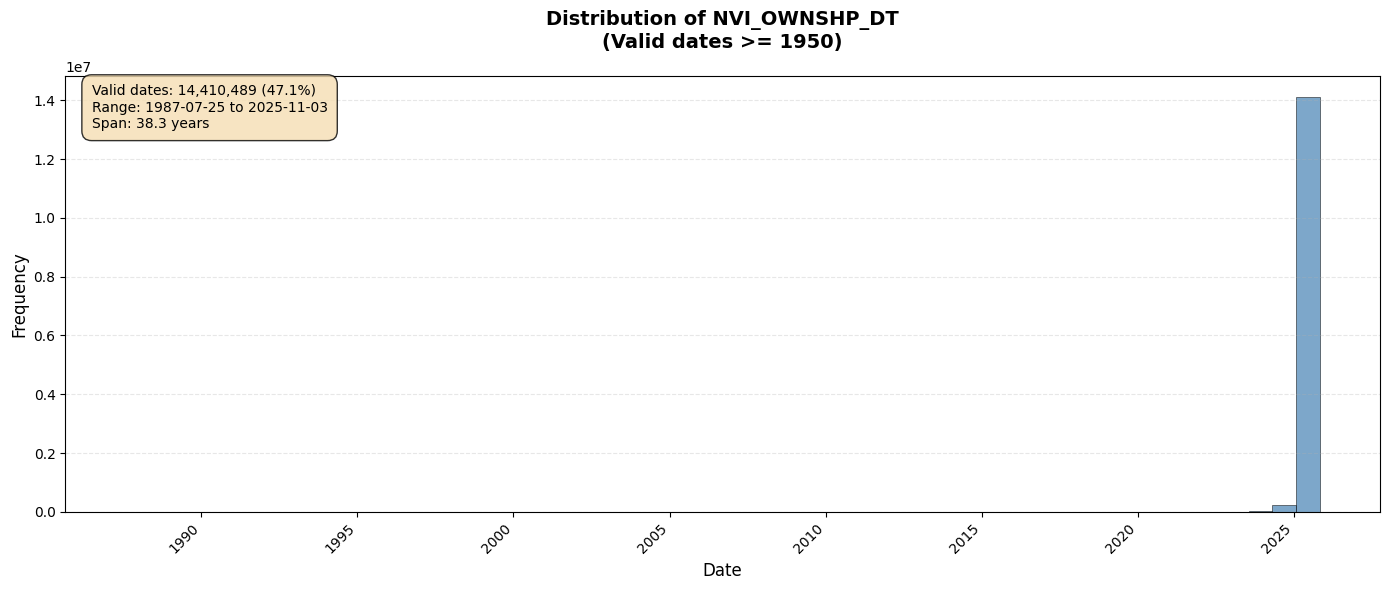

In [12]:
plot_valid_date_distribution(full_df_live, 'NVI_OWNSHP_DT')

## Plot Date Distribution Function

Function to visualize the distribution of dates in any column, filtering out invalid dates (before 1950).